In [ ]:
!pip install -q deepxde
# from google.colab import drive
# drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 5.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import deepxde as dde
from deepxde.geometry import geometry_2d
from deepxde.geometry import csg

from deepxde.geometry.geometry import Geometry
from deepxde.data.pde import PDE
from deepxde.backend import tf
from deepxde.model import Model
import matplotlib.pyplot as plt
import torch

from deepxde.icbc.boundary_conditions import PeriodicBC
from deepxde.icbc.boundary_conditions import DirichletBC
from deepxde.icbc.boundary_conditions import NeumannBC

# %env DDE_BACKEND=pytorch python pde.py

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


#1. Define the Simulation Domain

In [ ]:
D = 1

# Rectangular
Lx_min, Lx_max = -7.5 * D, 22.5 *D
Ly_min, Ly_max = -10 * D, 10 * D

# Spatial domain: X × Y = [-7.5*D; 22.5*D] × [−10*D, 10*D]
Rectangle = dde.geometry.Rectangle([Lx_min, Ly_min], [Lx_max, Ly_max])
# Cylinder
cylinder = geometry_2d.Polygon([[0, 0]] + [[D*np.cos(t), D*np.sin(t)] for t in np.linspace(0, 2*np.pi, 32)] + [[D, 0]])

space_domain = csg.CSGDifference(Rectangle, cylinder)
# Time domain: T = [0, 7]
time_domain = dde.geometry.TimeDomain(0, 7)
# Spatio-temporal domain
geomtime = dde.geometry.GeometryXTime(space_domain, time_domain)


#PDE and Boundary Conditions

In [ ]:
def pde(x,t):
  Re = 20
  Pe = 200
  u = t[:, 0:1]
  v = t[:, 1:2]
  p = t[:, 2:3]
  th = t[:, 3:4]

  du = tf.gradients(u, x)[0]
  dv = tf.gradients(v, x)[0]
  dp = tf.gradients(p, x)[0]
  dth = tf.gradients(th, x)[0]


  u_x, u_y, u_t = du[:, 0:1], du[:, 1:2], du[:,2:]

  u_xx = tf.gradients(u_x, x)[0][:, 0:1]
  u_yy = tf.gradients(u_y, x)[0][:, 1:2]

  v_x, v_y, v_t = dv[:, 0:1], dv[:, 1:2], dv[:,2:]

  v_xx = tf.gradients(v_x, x)[0][:, 0:1]
  v_yy = tf.gradients(v_y, x)[0][:, 1:2]

  p_x, p_y = dp[:, 0:1], dp[:, 1:2]


  th_x, th_y, th_t = dth[:, 0:1], dth[:, 1:2], dth[:,2:]
  th_xx = tf.gradients(th_x, x)[0][:, 0:1]
  th_yy = tf.gradients(th_y, x)[0][:, 1:2]

  heat_eq = (th_t) + (th * (u_x + u_y)) - ((1/Pe) * (th_xx + th_yy))
  heat_eq_v = (th_t) + (th * (v_x + v_y)) - ((1/Pe) * (th_xx + th_yy))
  nav_eq_u = (u_t) + (u * (u_x + u_y)) + (p_x + p_y) - ((1/Re) * (u_xx + u_yy))
  nav_eq_v = (v_t) + (u * (v_x + v_y)) + (p_x + p_y) - ((1/Re) * (v_xx + v_yy))
  continuity = u_x + u_y
  return [nav_eq_u,nav_eq_v,continuity,heat_eq]

In [ ]:
# Boundary conditions for Navier-stokes
def inflow_boundary(x, on_boundary):
    return on_boundary and np.isclose(x[0], Lx_min)

def outflow_boundary(x, on_boundary):
    return on_boundary and np.isclose(x[0], Lx_max)

def lateral_boundary(x, on_boundary):
    return on_boundary and (np.isclose(x[1], Ly_min) or np.isclose(x[1], Ly_max))


def zero_func(x) :
    return np.zeros([len(x),1])

bc_inlet_u = dde.icbc.DirichletBC(geomtime,zero_func,inflow_boundary,component=0)
bc_inlet_v = dde.icbc.DirichletBC(geomtime,zero_func,inflow_boundary,component=1)
bc_inlet_heat = dde.icbc.DirichletBC(geomtime, zero_func,inflow_boundary,component=3)

bc_lateral_v = dde.icbc.PeriodicBC(geomtime,0,lateral_boundary)
bc_lateral_heat = dde.icbc.PeriodicBC(geomtime,0,lateral_boundary)


bc_outflow_p = dde.icbc.DirichletBC(geomtime,zero_func,outflow_boundary,component=2)
heat_outflow_p = dde.icbc.NeumannBC(geomtime,zero_func,outflow_boundary,component=3)



#Data

In [ ]:
data = dde.data.TimePDE(
geomtime,
pde,
[bc_inlet_u,bc_inlet_v,bc_inlet_heat,bc_lateral_v,bc_lateral_heat,bc_outflow_p,heat_outflow_p],
num_domain = 20000,
num_boundary = 1400,
)


In [ ]:
data

# PINN Network For Cylinder


In [ ]:
# Neural Network setup
layer_size = [3] + [200] * 10 + [4]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)
model = dde.Model(data, net)

In [ ]:
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(iterations=50)

Compiling model...
'compile' took 8.919232 s

Initializing variables...
Training model...

Step      Train loss                                                                                                        Test loss                                                                                                         Test metric
0         [9.87e-04, 1.01e-03, 1.20e-03, 2.17e-03, 6.57e-02, 1.69e-02, 1.46e-01, 0.00e+00, 0.00e+00, 1.61e-02, 7.34e-05]    [9.87e-04, 1.01e-03, 1.20e-03, 2.17e-03, 6.57e-02, 1.69e-02, 1.46e-01, 0.00e+00, 0.00e+00, 1.61e-02, 7.34e-05]    []  
50        [2.08e-04, 2.24e-04, 1.55e-04, 1.19e-04, 7.20e-04, 4.70e-04, 1.57e-03, 0.00e+00, 0.00e+00, 1.66e-04, 1.72e-06]    [2.08e-04, 2.24e-04, 1.55e-04, 1.19e-04, 7.20e-04, 4.70e-04, 1.57e-03, 0.00e+00, 0.00e+00, 1.66e-04, 1.72e-06]    []  

Best model at step 50:
  train loss: 3.64e-03
  test loss: 3.64e-03
  test metric: []

'train' took 691.614613 s



Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


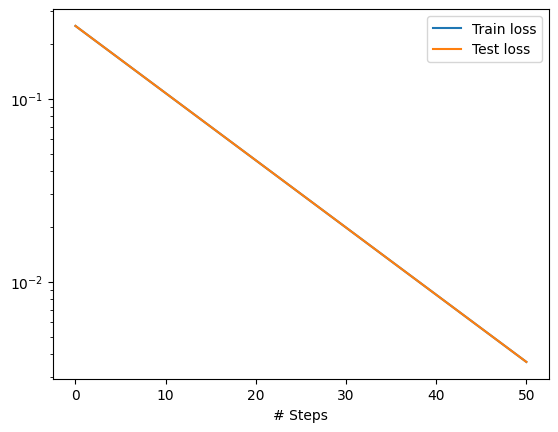

In [ ]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)
dde.utils.plot_best_state(train_state)

In [ ]:
def plot_boundary_conditions(pde_data):
    boundary_conditions = pde_data.bcs
    X_train = np.array(pde_data.train_x)

    plt.figure()
    ax = plt.axes(projection=Axes3D.name)

    mat = []
    for bc in boundary_conditions:
        x = bc.filter(X_train)
        val = bc.func(x)
        m = np.hstack((x, val))
        mat.append(m)

    mat = np.vstack(mat)
    ax.plot3D(mat[:, 0], mat[:, 1], mat[:, 2], ".")
    plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
plot_boundary_conditions(data)

In [ ]:
# Add anchors for RARpts # of points with highest Residual Error
x_id = np.argpartition(err_eq, -RARpts, axis=0)[-RARpts:]
data.add_anchors(X[x_id[:,-1]])